In [1]:
import mira
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

DIR = '/home/allen/Dropbox (Partners HealthCare)/shareseq_code_ocean/'

In [2]:
rna_data = anndata.read_h5ad(DIR + 'rna_data_raw_counts_only.h5ad')
rna_data.var_names = rna_data.var_names.str.upper()
rna_data.var_names_make_unique()
atac_data = anndata.read_h5ad(DIR + 'atac_data_raw_counts_only.h5ad')

In [3]:
sc.pp.filter_genes(rna_data, min_cells = 30)
sc.pp.filter_cells(rna_data, min_counts = 400)
sc.pp.filter_genes(rna_data, max_counts = 3e4)
sc.pp.filter_genes(rna_data, min_cells = 30)

rna_data.var['gene_counts'] = np.array(rna_data.X.sum(0)).reshape(-1)
sc.pp.calculate_qc_metrics(rna_data, log1p=False, inplace=True)
rna_data = rna_data[rna_data.obs.n_counts < 7500]

rna_data.raw = rna_data
sc.pp.normalize_total(rna_data, target_sum=1e4)
rna_data.layers['normalized'] = rna_data.X
sc.pp.log1p(rna_data)

sc.pp.highly_variable_genes(rna_data, min_disp = -0.1, min_mean = 0.0125)
rna_data.var['exogenous'] = rna_data.var.highly_variable
rna_data.var['endogenous'] = (rna_data.var.exogenous) & (rna_data.var.dispersions_norm > 0.7)

rna_data.X = rna_data.raw.X

In [4]:
cell_metadata = pd.read_csv(DIR + 'cell_metadata.tsv', sep = '\t').set_index('barcode')
rna_data.obs = rna_data.obs.join(cell_metadata[['celltype','true_cell']], how = 'left')
rna_data.obs.true_cell = rna_data.obs.true_cell.astype(str)

In [5]:
atac_data = atac_data[rna_data.obs_names]

In [6]:
rna_data.var.exogenous.sum(), rna_data.var.endogenous.sum()

(7560, 2338)

In [7]:
example_rna_model = mira.topics.ExpressionTopicModel(
    batch_size = 64,
    beta = 0.9182448347377409,
    encoder_dropout = 0.012078567225829858,
    endogenous_key = 'endogenous',
    exogenous_key = 'exogenous',
    min_learning_rate = 0.0023252511532295354, 
    max_learning_rate = 0.0799903648975615,
    num_epochs = 34,
    num_topics = 24,
    seed = 1410823976,
    nb_parameterize_logspace=True
).fit(rna_data)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exogenous
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endogenous
Epoch 35 done. Recent losses: 1.135e-01 --> 1.135e-01 --> 1.135e-01 --> 1.135e-01 --> 1.136e-01: 100%|████████████████████████████████████████| 34/34 [07:08<00:00, 12.59s/it]
INFO:mira.topic_model.base:Moving model to device: cpu


In [8]:
example_rna_model.predict(rna_data)
example_rna_model.get_umap_features(rna_data, box_cox = 0.22)

Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 14.18it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [9]:
example_atac_model = mira.topics.AccessibilityTopicModel(
    batch_size = 64,
    beta = 0.9089950520859839,
    encoder_dropout = 0.09653546113784024,
    endogenous_key = 'endogenous',
    max_learning_rate = 0.06793685541912606,
    min_learning_rate = 0.001414913157925883,
    num_epochs = 37,
    num_topics = 24,
    seed = 2258980095,
).fit(atac_data)

INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endogenous
Epoch 38 done. Recent losses: 5.219e-02 --> 5.218e-02 --> 5.216e-02 --> 5.215e-02 --> 5.215e-02: 100%|████████████████████████████████████████| 37/37 [17:50<00:00, 28.92s/it]
INFO:mira.topic_model.base:Moving model to device: cpu


In [10]:
rna_data = rna_data[cell_metadata.index.values]
atac_data = atac_data[rna_data.obs_names]

In [11]:
example_rna_model.predict(rna_data)
example_atac_model.predict(atac_data)

Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 13.64it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:30<00:00,  1.81it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.utils:28429 out of 28429 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features
/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categorie

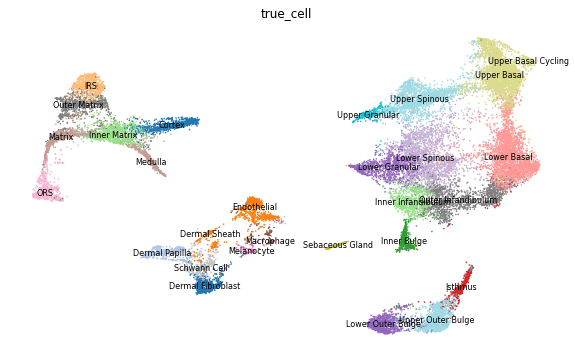

In [12]:
example_rna_model.get_umap_features(rna_data, box_cox = 0.22)
example_atac_model.get_umap_features(atac_data, box_cox = 0.22)

rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)
sc.pp.neighbors(rna_data, metric = 'manhattan', use_rep='X_joint_umap_features')
sc.tl.umap(rna_data, min_dist = 0.1, negative_sample_rate=5)

fig, ax = plt.subplots(1,1,figsize=(10,6))
sc.pl.umap(rna_data, color='true_cell', palette='tab20', frameon=False, ax = ax, show = False, legend_loc='on data', legend_fontsize=8, legend_fontweight=500, size= 10)
plt.show()

In [2]:
rna_data = anndata.read_h5ad(DIR + 'rna_data_raw_counts_only.h5ad')
rna_data.var_names = rna_data.var_names.str.upper()
rna_data.var_names_make_unique()
atac_data = anndata.read_h5ad(DIR + 'atac_data_raw_counts_only.h5ad')

cell_metadata = pd.read_csv(DIR + 'cell_metadata.tsv', sep = '\t').set_index('barcode')
rna_data.obs = rna_data.obs.join(cell_metadata[['celltype','true_cell']], how = 'left')
rna_data.obs.true_cell = rna_data.obs.true_cell.astype(str)

rna_data = rna_data[cell_metadata.index.values]
atac_data = atac_data[rna_data.obs_names]

In [3]:
rna_model = mira.topics.ExpressionTopicModel.load(DIR + 'shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load(DIR + 'shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [4]:
rna_model.predict(rna_data)
rna_model.get_umap_features(rna_data, box_cox = 0.23)
atac_model.predict(atac_data)
atac_model.get_umap_features(atac_data, box_cox = 0.23)

Predicting latent vars: 100%|████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 13.82it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
Predicting latent vars: 100%|████████████████████████████████████████████████████████████████| 56/56 [00:29<00:00,  1.89it/s]
INFO:mira.adata_interface

In [6]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

sc.pp.neighbors(rna_data, metric = 'manhattan', use_rep='X_joint_umap_features', n_neighbors=20)
sc.tl.umap(rna_data, min_dist = 0.1)

INFO:mira.adata_interface.utils:28429 out of 28429 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical


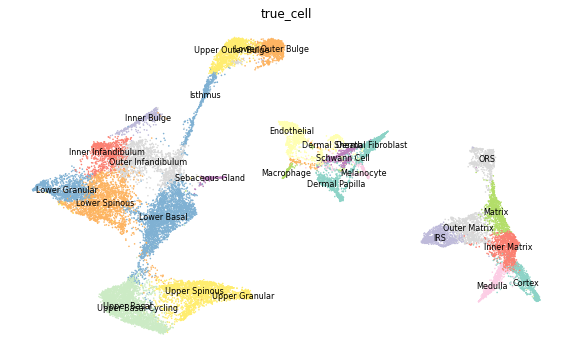

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sc.pl.umap(rna_data, color='true_cell', palette='Set3', frameon=False, ax = ax, show = False, legend_loc='on data', legend_fontsize=8, legend_fontweight=500, size= 10)
plt.show()

In [8]:
populations = ['Cortex', 'IRS', 'Inner Bulge', 'Inner Infandibulum',
       'Inner Matrix', 'Isthmus', 'Lower Basal', 'Lower Granular',
       'Lower Outer Bulge', 'Lower Spinous', 'Matrix', 'Medulla', 'ORS',
       'Outer Infandibulum', 'Outer Matrix', 'Upper Basal',
       'Upper Basal Cycling', 'Upper Granular', 'Upper Outer Bulge',
       'Upper Spinous']

In [9]:
rna_data = rna_data[rna_data.obs.true_cell.isin(populations)]
atac_data = atac_data[rna_data.obs_names]

In [10]:
with open(DIR + 'rp_model_genes.txt','r') as f:
    rp_genes = [x.strip() for x in f]

In [11]:
tss_data = pd.read_csv(DIR + 'mm10_canonical_tss.tsv', sep = '\t')
tss_data.head(3)

,name,chrom,strand,txStart,txEnd,geneSymbol,chromStart,chromEnd,transcript
0,ENSMUST00000193812.1,chr1,+,3073252,3074322,4933401J01RIK,3073252.0,3074322.0,ENSMUST00000193812.1
1,ENSMUST00000082908.1,chr1,+,3102015,3102125,GM26206,3102015.0,3102125.0,ENSMUST00000082908.1
2,ENSMUST00000159265.1,chr1,-,3206522,3215632,XKR4,NaN,NaN,NaN


In [12]:
mira.tl.get_distance_to_TSS(atac_data, tss_data=tss_data, genome_file=DIR+'mm10.genome')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [ ]:
rp_args = dict(expr_adata = rna_data, atac_adata = atac_data)
litemodel = mira.rp.LITE_Model(expr_model=rna_model, accessibility_model=atac_model, 
                               genes=rp_genes)\
        .fit(**rp_args, callback=mira.rp.SaveCallback(DIR + 'rp_models/'))

In [ ]:
nitemodel = mira.rp.NITE_Model(expr_model=rna_model, accessibility_model=atac_model, 
                               genes=np.intersect1d(rp_genes, litemodel.genes), initialization_model= litemodel)\
        .fit(**rp_args, callback=mira.rp.SaveCallback(DIR + 'rp_models/'))

In [160]:
del litemodel
del nitemodel

litemodel = mira.rp.LITE_Model.load_dir(expr_model=rna_model, accessibility_model=atac_model, 
                               prefix = DIR + 'rp_models/')

nitemodel = mira.rp.NITE_Model.load_dir(expr_model=rna_model, accessibility_model=atac_model, 
                               prefix = DIR + 'rp_models/')

In [165]:
litemodel.get_logp(**rp_args)
litemodel.predict(**rp_args)

nitemodel.get_logp(**rp_args)
nitemodel.predict(**rp_args)

Getting logp(Data):   0%|                                                                           | 0/4883 [00:00<?, ?it/s]/home/allen/projects/liulab/multiomics/mira/MIRA/mira/rp_model/rp_model.py:492: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
Getting logp(Data): 100%|████████████████████████████████████████████████████████████████| 4883/4883 [16:33<00:00,  4.91it/s]
INFO:mira.adata_interface.core:Added layer: LITE_logp
Predicting expression: 100%|█████████████████████████████████████████████████████████████| 4883/4883 [16:18<00:00,  4.99it/s]
INFO:mira.adata_interface.core:Added layer: LITE_prediction
Getting logp(Data): 100%|████████████████████████████████████████████████████████████████| 4882/4882 [16:37<00:00,  4.90it/s]
INFO:mira.adata_interface.core:Added layer: NITE_logp
Predict

In [166]:
rna_data.write_h5ad(DIR + 'checkpoint_rna_data.h5ad')
atac_data.write_h5ad(DIR + 'checkpoint_atac_data.h5ad')

In [167]:
mira.tl.get_motif_hits_in_peaks(atac_data, genome_fasta = DIR + 'mm10.fa')

mira.utils.subset_factors(atac_data, use_factors=rna_data.var_names)

INFO:mira.tools.motif_scan:Getting peak sequences ...
334124it [00:05, 55774.28it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits 

In [20]:
rna_data.obs = rna_data.obs.join(atac_data.obs[atac_model.topic_cols], rsuffix='_atac', how = 'left')

In [168]:
litemodel.probabilistic_isd(**rp_args, checkpoint=DIR + 'pISD_checkpoint.h5')

Predicting TF influence: 100%|█████████████████████████████████████████████████████████| 4883/4883 [2:17:00<00:00,  1.68s/it]
INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [236]:
rna_data.write_h5ad(DIR + 'checkpoint_rna_data.h5ad')
atac_data.write_h5ad(DIR + 'checkpoint_atac_data.h5ad')

import mira
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

DIR = '/home/allen/Dropbox (Partners HealthCare)/shareseq_code_ocean/'

rna_model = mira.topics.ExpressionTopicModel.load(DIR + 'Shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load(DIR + 'shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

#rna_data = anndata.read_h5ad(DIR + 'lite_rna_data.h5ad')
rna_data = anndata.read_h5ad(DIR + 'checkpoint_rna_data.h5ad')
atac_data = anndata.read_h5ad(DIR + 'checkpoint_atac_data.h5ad')

with open(DIR + 'rp_model_genes.txt','r') as f:
    rp_genes = [x.strip() for x in f]

In [169]:
mira.tl.get_NITE_score_cells(rna_data)
mira.tl.get_NITE_score_genes(rna_data)
mira.tl.get_chromatin_differential(rna_data)

with open(DIR + 'HF_cells.txt', 'r') as f:
    hf_cells = [x.strip() for x in f]

INFO:mira.adata_interface.lite_nite:Added keys to obs: NITE_score, nonzero_counts
INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts
INFO:mira.adata_interface.core:Added layer: chromatin_differential


In [170]:
hair_follicle = rna_data[hf_cells]

In [171]:
sc.pp.neighbors(hair_follicle, metric='manhattan', use_rep='X_joint_umap_features')
sc.tl.umap(hair_follicle, min_dist=0.1)

hair_follicle.obsm['X_joint_umap_features'] = rna_data[hair_follicle.obs_names].obsm['X_joint_umap_features']

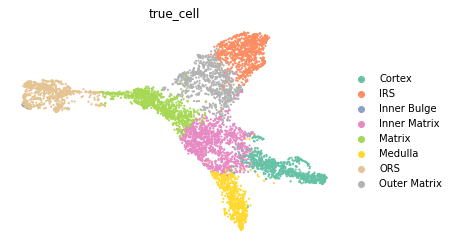

In [172]:
sc.pl.umap(hair_follicle, color = 'true_cell', palette='Set2', frameon=False)

In [177]:
sc.tl.diffmap(hair_follicle)
mira.time.normalize_diffmap(hair_follicle)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 5 diffusion map components.


/home/allen/projects/liulab/multiomics/mira/MIRA/mira/plots/eigengap_plot.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(len(eigvals)-1), eigvals[1:], '--bo', c = 'black')


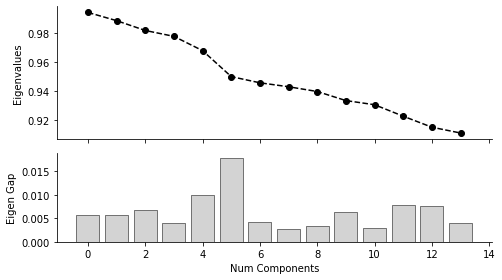

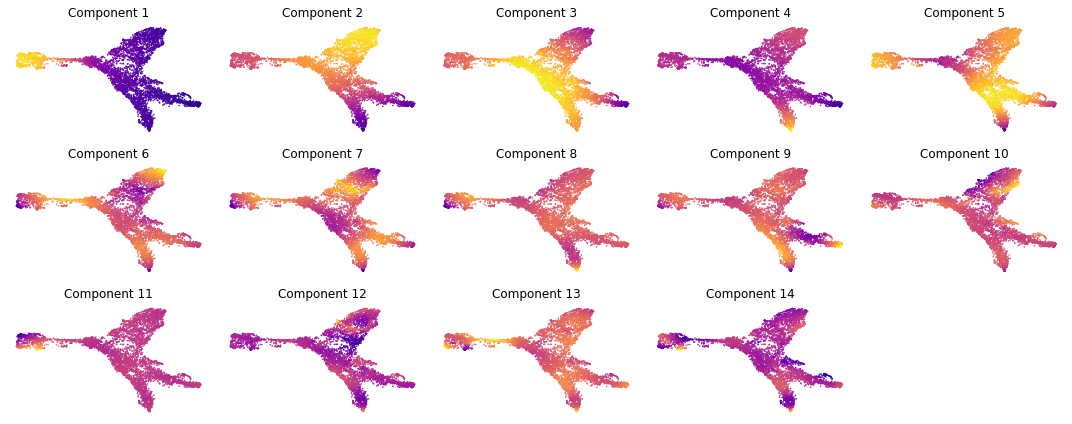

In [178]:
mira.pl.plot_eigengap(hair_follicle)
plt.show()

In [179]:
sc.pp.neighbors(hair_follicle, n_neighbors = 30, use_rep = "X_diffmap", key_added = "X_diffmap", n_pcs = 4)
mira.time.get_connected_components(hair_follicle)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


In [182]:
mira.time.get_transport_map(hair_follicle, n_jobs = 5,
                            start_cell=int(atac_data[hair_follicle.obs_names].obs.topic_10.argmax()))

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
Calculating pseudotime:   8%|████▍                                                   | 4429/55350 [00:00<00:04, 11043.74it/s]
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


In [190]:
terminal_cells = mira.time.find_terminal_cells(hair_follicle, threshold=5e-3)
terminal_cells

INFO:mira.pseudotime.pseudotime:Found 5 terminal states from stationary distribution.


array(['R1.30.R2.68.R3.84.P1.56', 'R1.80.R2.57.R3.65.P1.54',
       'R1.87.R2.11.R3.05.P1.55', 'R1.27.R2.23.R3.18.P1.54',
       'R1.43.R2.55.R3.41.P1.55'], dtype=object)

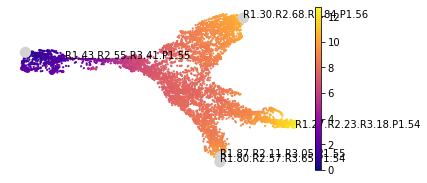

In [191]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
sc.pl.umap(hair_follicle, color = 'mira_pseudotime', color_map='plasma', frameon=False, ax = ax, show = False)
sc.pl.umap(hair_follicle[list(terminal_cells[:3]) + [hair_follicle.uns['start_cell']]], size = 500,frameon=False, ax = ax, show = False)
for t in terminal_cells:
    c = hair_follicle[t].obsm['X_umap'].reshape(-1)
    ax.text(x = c[0], y = c[1], s = str(t))

In [192]:
mira.time.get_branch_probabilities(hair_follicle, terminal_cells={'Medulla' : 'R1.80.R2.57.R3.65.P1.54', 'Cortex' : 'R1.27.R2.23.R3.18.P1.54', 'IRS' : 'R1.30.R2.68.R3.84.P1.56'})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


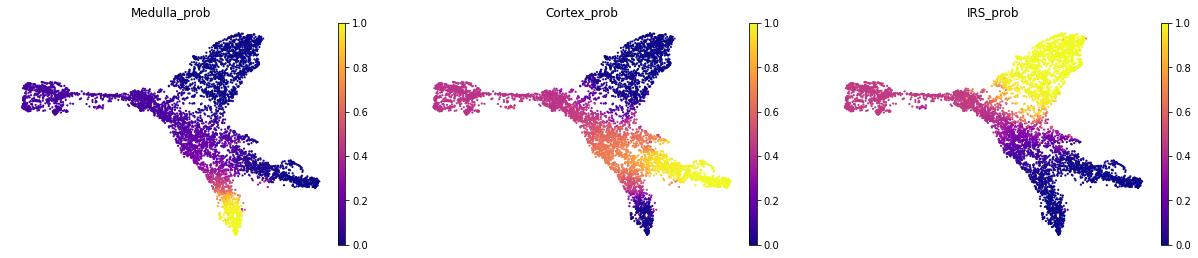

In [193]:
sc.pl.umap(hair_follicle, color = ['Medulla_prob','Cortex_prob','IRS_prob'], color_map='plasma', frameon=False)

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


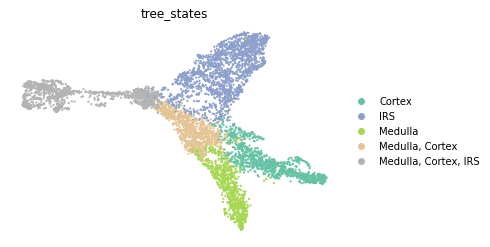

In [210]:
mira.time.get_tree_structure(hair_follicle, threshold=0.7)
sc.pl.umap(hair_follicle, color = 'tree_states', palette='Set2', frameon=False)

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

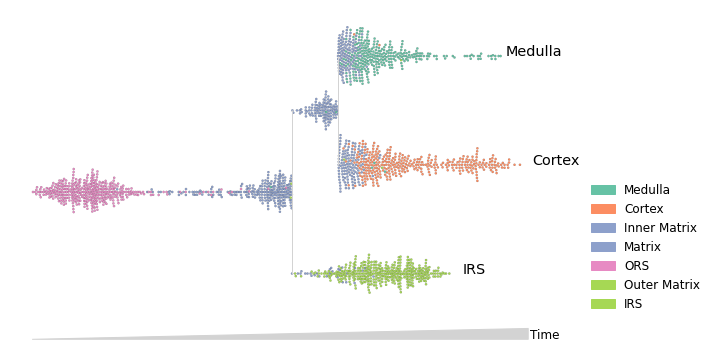

In [211]:
c = sns.color_palette('Set2')
hair_follicle.obs.true_cell = hair_follicle.obs.true_cell.astype(str)
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.true_cell.isin(['Cortex','IRS','Inner Matrix','Matrix', 'Medulla', 'ORS', 'Outer Matrix'])], 
                    data= 'true_cell', style='swarm', log_pseudotime=False, size=5,
                   palette=[c[0],c[1],c[2],c[2],c[3],c[4],c[4]], hue_order=['Medulla','Cortex','Inner Matrix','Matrix','ORS','Outer Matrix','IRS'],
                    max_swarm_density=100)

In [212]:
hair_follicle.obs['adjusted_pseudotime'] = np.log10(hair_follicle.obs.mira_pseudotime - 5 + 0.00001)

/home/allen/envs/mira/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


join_cols = atac_data[hair_follicle.obs_names].obs[atac_model.topic_cols]
join_cols.columns+='_atac'
hair_follicle.obs = hair_follicle.obs.join(join_cols, how='left')

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

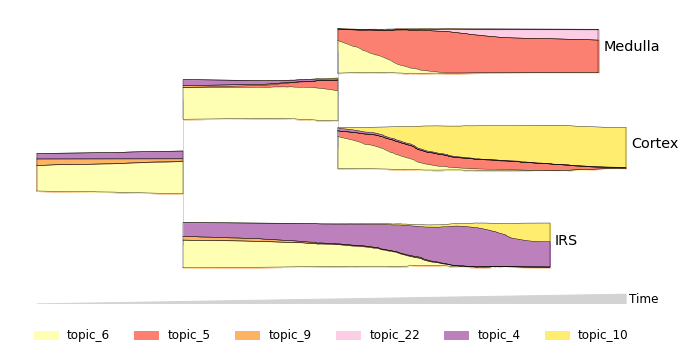

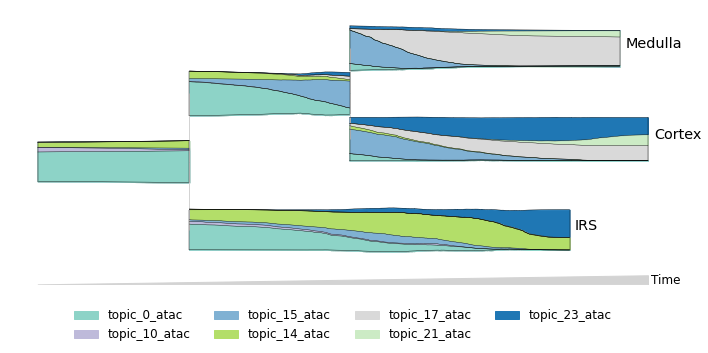

In [213]:
stream_kwargs = dict(hide_feature_threshold=0.03, window_size=301, linewidth=0.4, pseudotime_key = 'adjusted_pseudotime',log_pseudotime=False)

mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 6], 
                    data = ['topic_9','topic_6','topic_10','topic_5','topic_4','topic_22'],                      
                   palette=sns.color_palette('Set3')[1::2], legend_cols=7, **stream_kwargs)

mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 6], 
                    data = ['topic_10_atac','topic_0_atac','topic_15_atac','topic_17_atac','topic_14_atac','topic_23_atac', 'topic_21_atac'],
                   palette=[*sns.color_palette('Set3')[::2], *sns.color_palette('tab20')[:2]],legend_cols=4, **stream_kwargs)

Finding enrichments: 100%|████████████████████████████████████████████████████████████████| 555/555 [00:02<00:00, 204.54it/s]


<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

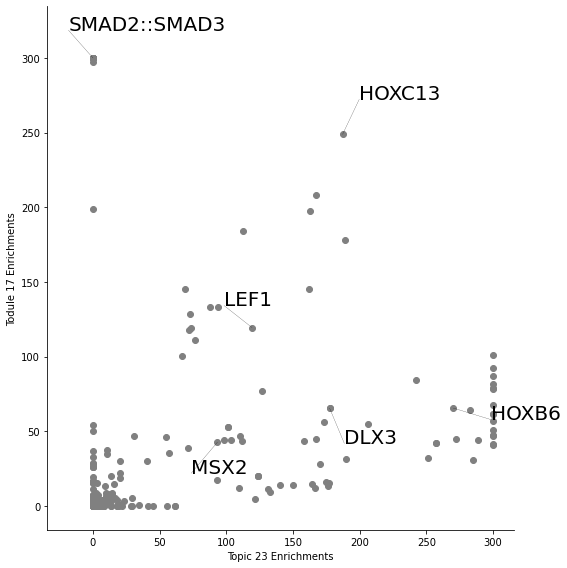

In [214]:
atac_model.get_enriched_TFs(atac_data, topic_num=17, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=23, top_quantile=0.1)

atac_model.plot_compare_topic_enrichments(23, 17, label_factors = ['LEF1','HOXC13','HOXB6','MSX2','DLX3','SMAD2::SMAD3'],
                                           fontsize=20, label_closeness=5)

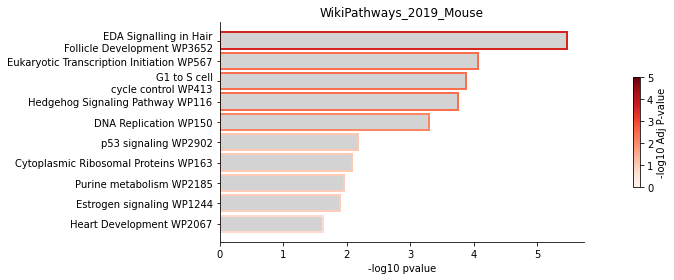

In [215]:
import logging
logging.getLogger().setLevel(logging.WARN)
rna_model.post_topic(6, 500)
rna_model.fetch_topic_enrichments(6, ontologies=['WikiPathways_2019_Mouse'])

rna_model.plot_enrichments(6, show_genes=False)
logging.getLogger().setLevel(logging.INFO)

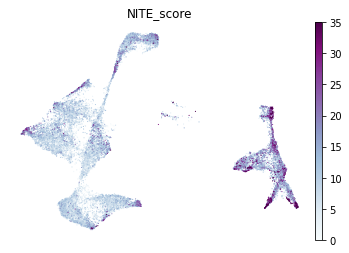

In [216]:
sc.pl.umap(rna_data, color = 'NITE_score', vmax = 35, color_map = 'BuPu', vmin = 0, frameon=False)

In [217]:
sc.pp.normalize_total(rna_data, target_sum=1e4, layer = None)
rna_data.layers['normalized'] = rna_data.X
rna_data.layers['smoothed'] = rna_data.obsp['connectivities'].dot(rna_data.X)#knn smooth for visualization

In [218]:
for layer in ['chromatin_differential','LITE_prediction','NITE_prediction', 'normalized','smoothed']:
    hair_follicle.layers[layer] = rna_data[hair_follicle.obs_names, hair_follicle.var_names].layers[layer]

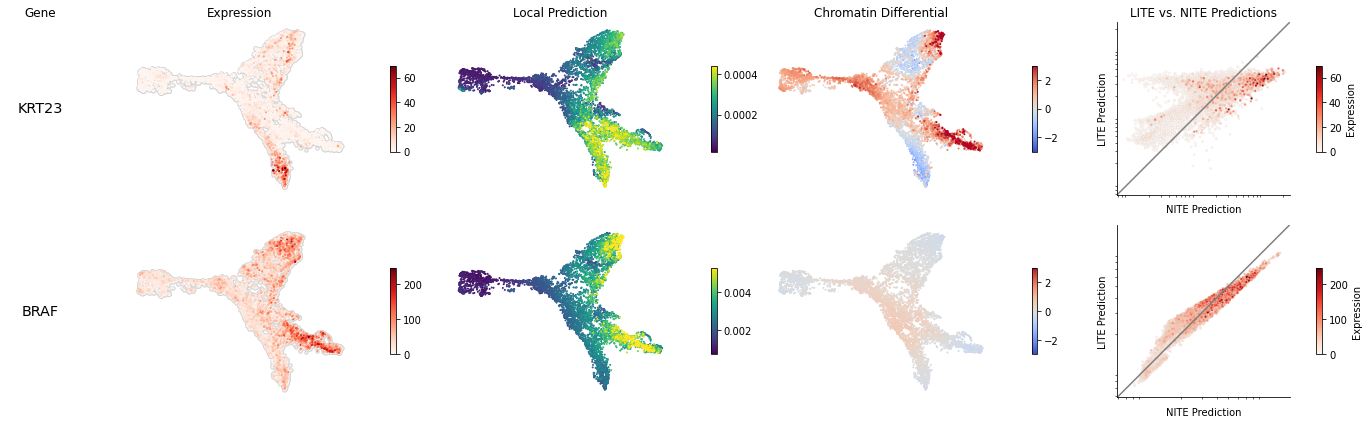

In [238]:
mira.pl.plot_chromatin_differential(hair_follicle, genes = ['KRT23','BRAF'], counts_layer='smoothed',
                                   trim_lite_prediction=2)
plt.show()

In [220]:
from mira.plots.base import map_plot

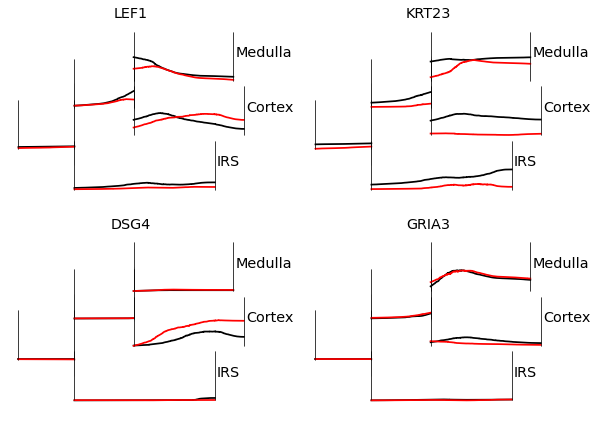

In [221]:
compare_stream_kwargs = dict(style = 'line', show_legend=False,
                             max_bar_height=0.9, scale_features=True, clip=5, 
                             order=None, palette=['red','black'],
                             figsize=(4,3), layers = ['smoothed','LITE_prediction'], 
                             window_size = 351, log_pseudotime = False, 
                             pseudotime_key = 'adjusted_pseudotime', pseudotime_triangle = False)

def make_plot(ax, gene):
    mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime>6], ax = ax,
                    title = gene, data = [gene, gene], **compare_stream_kwargs)

map_plot(make_plot, [[gene] for gene in ['LEF1','KRT23','DSG4','GRIA3']], 
         plots_per_row=2,  height = 3, aspect = 1.4)
plt.show()

In [207]:
hair_follicle.write_h5ad(DIR + 'hair_follicle.h5ad')

/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical


import mira
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

DIR = ''

rna_model = mira.topics.ExpressionTopicModel.load(DIR + 'shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load(DIR + 'shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

#rna_data = anndata.read_h5ad(DIR + 'lite_rna_data.h5ad')
rna_data = anndata.read_h5ad(DIR + 'lite_isd_rna_data.h5ad')
atac_data = anndata.read_h5ad(DIR + 'lite_atac_data.h5ad')

with open(DIR + 'rp_model_genes.txt','r') as f:
    rp_genes = [x.strip() for x in f]

mira.tl.get_NITE_score_genes(rna_data)

hair_follicle = anndata.read_h5ad(DIR + 'hair_follicle.h5ad')

In [160]:
hair_follicle = anndata.read_h5ad(DIR + 'hair_follicle.h5ad')

In [222]:
with open(DIR + 'rp_model_genes.txt','r') as f: 
    rp_genes = [x.strip() for x in f]

In [223]:
tree_states = pd.read_csv(DIR + 'tree_states.tsv', sep = '\t')
hair_follicle.obs = hair_follicle.obs.drop(columns = 'tree_states').join(tree_states.set_index('barcode'), how = 'left')
hair_follicle = hair_follicle[:, np.union1d(rp_genes, litemodel.genes) ]

In [224]:
hair_follicle.obs['branch_cell'] = np.isin(np.arange(len(hair_follicle)), atac_data[hair_follicle.obs_names].obs.topic_15.argsort().tail(150).values)
hair_follicle.var['branch_chromdiff'] = np.nanmean(hair_follicle[hair_follicle.obs.branch_cell,:].layers['chromatin_differential'].toarray(), axis = 0)

Trying to set attribute `.obs` of view, copying.


In [226]:
sc.tl.rank_genes_groups(hair_follicle, groupby='tree_states', groups=['Cortex'], reference='Medulla', method='wilcoxon')
lineage_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Cortex').set_index('names')
lineage_DE_genes = lineage_DE[(lineage_DE.pvals_adj <= 0.1) & (np.abs(lineage_DE.logfoldchanges) >= 1)].index.values

fig4_genes = np.intersect1d(lineage_DE_genes, atac_data.uns['distance_to_TSS_genes'])

hair_follicle.obs['hairshaft'] = hair_follicle.obs.tree_states.map({'Cortex' : 'Cortex', 'Medulla': 'Medulla', 'Medulla, Cortex' : 'pre-HS', 'Medulla, Cortex, IRS' : 'pre-HS', 'IRS' : 'IRS'})

sc.tl.rank_genes_groups(hair_follicle, groupby='hairshaft', groups=['Cortex','Medulla'], reference='pre-HS', method='wilcoxon')
medulla_hairshaft_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Medulla')
cortex_hairshaft_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Cortex')

not_expressed_at_branch_genes = np.union1d(
    medulla_hairshaft_DE[(medulla_hairshaft_DE.logfoldchanges > 1) & (medulla_hairshaft_DE.pvals_adj < 0.1)].names.values,
    cortex_hairshaft_DE[(cortex_hairshaft_DE.pvals_adj < 0.1) & (cortex_hairshaft_DE.logfoldchanges > 1)].names.values)

hair_follicle.var['isd_genes'] = hair_follicle.var_names.isin(fig4_genes)
hair_follicle.var['expressed_at_branch'] = ~hair_follicle.var_names.isin(not_expressed_at_branch_genes) & hair_follicle.var.isd_genes
hair_follicle.var['NITE_score'] = rna_data.var['NITE_score']
hair_follicle.var['accessible_at_branch'] = (hair_follicle.var.branch_chromdiff > 0.15) & (hair_follicle.var.NITE_score > 5) & hair_follicle.var.isd_genes & ~hair_follicle.var.expressed_at_branch
hair_follicle.var['accessible_after_branch'] = ~(hair_follicle.var.expressed_at_branch | hair_follicle.var.accessible_at_branch) & hair_follicle.var.isd_genes
hair_follicle.var['cortex_DE'] = ((lineage_DE.logfoldchanges.values > 1) & (lineage_DE.pvals_adj < 0.1)) & (lineage_DE.logfoldchanges > 1)
hair_follicle.var['medulla_DE'] = ((lineage_DE.logfoldchanges.values < 1) & (lineage_DE.pvals_adj < 0.1)) & (lineage_DE.logfoldchanges < -1)

/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical
/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


/home/allen/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hairshaft' as categorical


In [227]:
import seaborn as sns

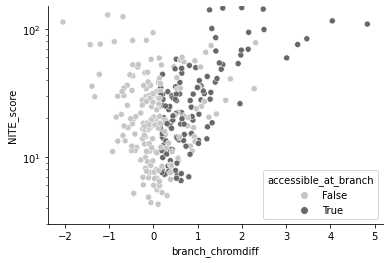

In [228]:
ax = sns.scatterplot(
    data=hair_follicle.var.loc[lineage_DE_genes],
    x = 'branch_chromdiff',
    y = 'NITE_score',
    hue = 'accessible_at_branch',
    palette='Greys'
)
ax.set(yscale = 'log')
ax.set(ylim = (3, 150))
sns.despine()

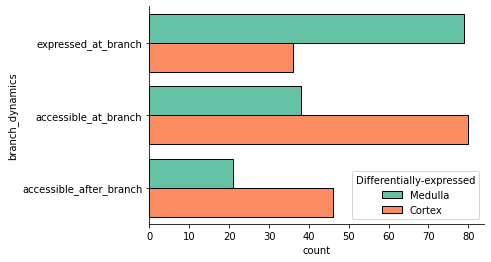

In [229]:
categories = np.array(['expressed_at_branch','accessible_at_branch','accessible_after_branch'])
hair_follicle.var['branch_dynamics'] = categories[hair_follicle.var[categories].values.argmax(-1)]

hair_follicle.var['Differentially-expressed'] = np.where(hair_follicle.var.cortex_DE, 'Cortex','Medulla')

sns.countplot(data = hair_follicle.var[hair_follicle.var.isd_genes],
             y = 'branch_dynamics', hue = 'Differentially-expressed', order = categories,
             palette = 'Set2', saturation=1., edgecolor = 'black')
sns.despine()

In [230]:
cortex_primed = hair_follicle.var_names[hair_follicle.var.isd_genes & hair_follicle.var.accessible_at_branch & hair_follicle.var.cortex_DE].values
medulla_primed = hair_follicle.var_names[hair_follicle.var.isd_genes & hair_follicle.var.accessible_at_branch & hair_follicle.var.medulla_DE].values

In [231]:
order = cortex_primed
plot_data = hair_follicle[hair_follicle.obs.tree_states.str.contains('Cortex') \
                                          & (hair_follicle.obs.mira_pseudotime > 6.5) & (hair_follicle.obs.mira_pseudotime < 11.5)]
corrs = [
    np.corrcoef(np.log(plot_data.obs_vector('topic_15_atac')), np.log(plot_data.obs_vector(gene, layer = 'LITE_prediction')))[0,1]
    for gene in order
]
order = order[np.argsort(corrs)[::-1]]
plot_data.layers['LITE_prediction'] = np.log(plot_data.layers['LITE_prediction'].toarray())

/home/allen/envs/mira/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


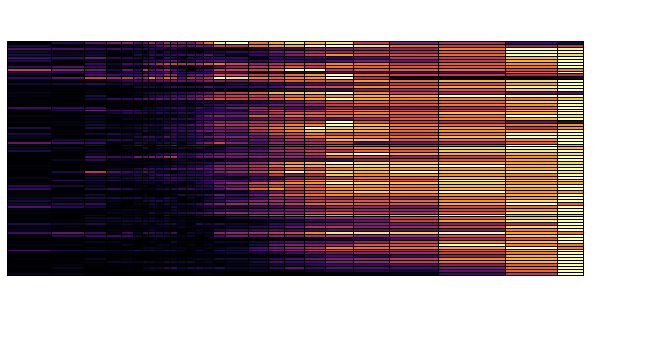

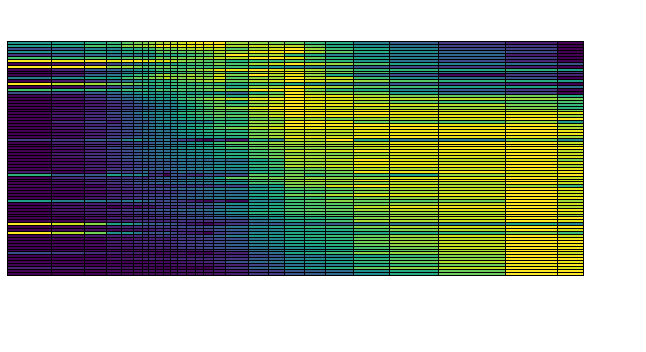

In [232]:
_, ax = mira.pl.plot_stream(plot_data, 
                data = list(order), layers = 'smoothed', palette='inferno', linecolor = None, 
                   window_size=81, style='heatmap', order = None, pseudotime_triangle=False)
ax.set(yticks = [])

_, ax = mira.pl.plot_stream(plot_data, 
                   data = list(order), layers = 'LITE_prediction', palette='viridis', linecolor = None,
                   window_size=81, style='heatmap', order = None, pseudotime_triangle=False)
ax.set(yticks = [])
plt.show()

hair_follicle.varm['motifs-prob_deletion'][:, np.argwhere(hair_follicle.uns['motifs']['name'] == 'FOS-1')[0,0]] = np.nan

INFO:mira.tools.tf_targeting:Testing with 80 query genes and 4583 background genes, against 555 factors
Testing factors: 100%|████████████████████████████████████████████████████████████████████| 555/555 [00:01<00:00, 403.70it/s]
INFO:mira.tools.tf_targeting:Testing with 38 query genes and 4583 background genes, against 555 factors
Testing factors: 100%|████████████████████████████████████████████████████████████████████| 555/555 [00:01<00:00, 437.79it/s]


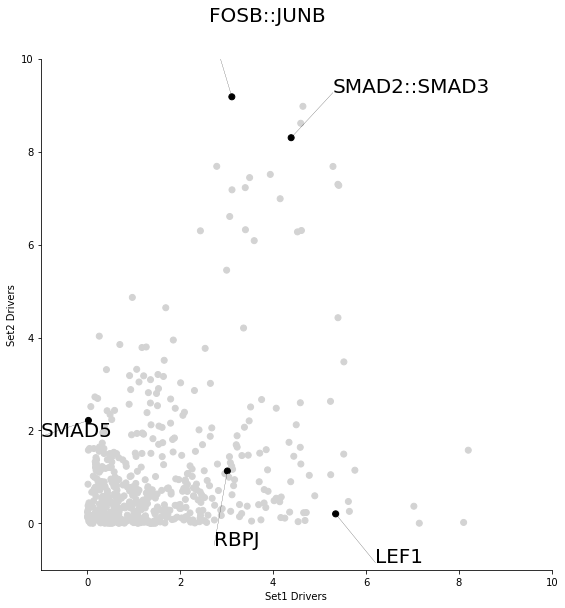

In [235]:
label = ['LEF1','RBPJ','SMAD2::SMAD3','SMAD5','FOSB::JUNB']
ax = mira.pl.compare_driver_TFs_plot(hair_follicle, color = 'lightgrey', fontsize=20,
            geneset1=cortex_primed, geneset2=medulla_primed,
            label_factors=label, palette = 'Greys_r', ax = None,
            background = np.setdiff1d(litemodel.genes, lineage_DE_genes),
            hue = {factor : 1. for factor in label}, show_legend=False,            
)
plt.axis('square')
ax.set(ylim = (-1,10),xlim = (-1,10))
plt.show()